# Analysis of Covid-19 Vaccine Tweets with Predicted Sentiment

This notebook is about analyzing the Covid-19 vaccine tweets where the sentiment of the tweets are already predicted using the fine-tune BERT model. There will be 2 new columns added to the Covid-19 vaccine tweet dataframe after the Covid-19 vaccine tweet dataset is loaded into a dataframe. 

The first column to be added -- called **'vax_type'** -- will be a column that stores the vaccine type that was mentioned in the tweet. If the tweet does not mention any vaccine type, then the column will store **'nan'** for that tweet. 

The second column to be added -- called **'loc_label'** -- will be a column that stores the location of the user that posted his/her tweet. There will be only certain tweet that will be labelled as its respective user location/cuontry as those country are targetted to be studied. As such, other countries or user that does not have a location will be labelled as **'other'**.

There will be a third column, **'sentiment_num'** added to the dataset that contains the numerical representation of the sentiment of the Covid-19 vaccine tweet. After the 2 columns are added, the analysis of Covid-19 vaccine tweets will be commenced.

In [1]:
# utilities
import re
import numpy as np
import pandas as pd
import random
import math

#import seaborn and matplotlib library for plotting graph
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px

import time
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

#warnings
import warnings
warnings.filterwarnings('ignore')

#wordcloud and spelling check for words
from wordcloud import WordCloud, ImageColorGenerator
import wordninja
from spellchecker import SpellChecker
from collections import Counter

import nltk
# nltk.download('wordnet')  #uncomment to run first time then comment after running first time
# nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 

#import keybert for extracting keywords
from keybert import KeyBERT
from transformers import AutoModel
#import pygooglenews for google news query with extracted keyword
from pygooglenews import GoogleNews

# configure graph style when plotting graph
%config InlineBackend.figure_format='retina'
sns.set(style='darkgrid', palette='muted', font_scale=1.5)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

In [2]:
#load covid-19 vaccine tweet with predicted sentiment dataset
df_vax = pd.read_csv('predicted_vaccination_tweets.csv')
df_vax.drop(df_vax[df_vax.sentiment.isnull()].index, inplace=True)  #remove rows of tweet without sentiment value
# Remove today's date since data is incomplete
today = pd.Timestamp.today().date()
df_vax = df_vax[df_vax['date']!=today]
df_vax.sentiment = df_vax.sentiment.astype('category')  #convert 'Sentiment' column into categorical value type

#add 'sentiment_num' column and convert into integer data type
df_vax['sentiment_num'] = df_vax['sentiment'].map({'negative':-1,'neutral':0,'positive':1})
df_vax.sentiment_num = df_vax.sentiment_num.astype('int32')
df_vax.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148586 entries, 0 to 148591
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   id             148586 non-null  object  
 1   user_location  99748 non-null   object  
 2   date           148586 non-null  object  
 3   text           148586 non-null  object  
 4   hashtags       115694 non-null  object  
 5   sentiment      148586 non-null  category
 6   sentiment_num  148586 non-null  int32   
dtypes: category(1), int32(1), object(5)
memory usage: 7.5+ MB


In [3]:
#add column 'vax_type' to dataframe using np.select method
all_vax = ['covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik']

#set condition for value of each row in 'vax_type' column
vax_conditions = [df_vax['text'].str.lower().str.contains(all_vax[0]),
    df_vax['text'].str.lower().str.contains(all_vax[1]),
    df_vax['text'].str.lower().str.contains(all_vax[2]),
    df_vax['text'].str.lower().str.contains(all_vax[3]),
    df_vax['text'].str.lower().str.contains(all_vax[4]),
    df_vax['text'].str.lower().str.contains(all_vax[5]),
    df_vax['text'].str.lower().str.contains(all_vax[6]),
    df_vax['text'].str.lower().str.contains(all_vax[7]),
    df_vax['text'].str.lower().str.contains(all_vax[8])]

vax_label = np.select(vax_conditions, all_vax, np.nan)
df_vax['vax_type'] = vax_label

In [4]:
#add column 'loc_label' to dataframe using np.select method
countries=['india','usa','canada','spain','uk','brazil', 'australia', 'japan', 'malaysia']

#set condition for value of each row in 'loc_label' column
country_conditions = [df_vax['user_location'].str.lower().str.contains(countries[0], na=False),
    df_vax['user_location'].str.lower().str.contains(countries[1], na=False),
    df_vax['user_location'].str.lower().str.contains(countries[2], na=False),
    df_vax['user_location'].str.lower().str.contains(countries[3], na=False),
    df_vax['user_location'].str.lower().str.contains(countries[4], na=False),
    df_vax['user_location'].str.lower().str.contains(countries[5], na=False),
    df_vax['user_location'].str.lower().str.contains(countries[6], na=False),
    df_vax['user_location'].str.lower().str.contains(countries[7], na=False),
    df_vax['user_location'].str.lower().str.contains(countries[8], na=False)]

loc_label = np.select(country_conditions, countries, 'other')
df_vax['loc_label'] = loc_label

#display dataframe info after adding column 
df_vax.info()
#save dataframe with added column as csv file to file path destination
df_vax.to_csv("labelled_predict_vax_tweet.csv", index=False)
df_vax.head(5)  #display first 5 rows of dataframe

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148586 entries, 0 to 148591
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   id             148586 non-null  object  
 1   user_location  99748 non-null   object  
 2   date           148586 non-null  object  
 3   text           148586 non-null  object  
 4   hashtags       115694 non-null  object  
 5   sentiment      148586 non-null  category
 6   sentiment_num  148586 non-null  int32   
 7   vax_type       148586 non-null  object  
 8   loc_label      148586 non-null  object  
dtypes: category(1), int32(1), object(7)
memory usage: 9.8+ MB


id  user_location        date  \
0  1396819543234736129  Jaipur, India  2021-05-24   
1  1396819242905837568  Mumbai, India  2021-05-24   
2  1396795781714268161     Dubai, UAE  2021-05-24   
3  1396795009022586881  Jaipur, India  2021-05-24   
4  1396768142299332608  Mumbai, India  2021-05-24   

                                                text  \
0  Discussions underway with GOI for supply of #P...   
1  Pfizer-BioNTech COVID-19 Vaccine in India Soon...   
2  The @DHA_Dubai has opened up appointments for ...   
3  #Pfizer’s discussions with the Government of I...   
4  #PfizerBioNTech is better than #AstraZenaca In...   

                            hashtags sentiment  sentiment_num vax_type  \
0                 ['PfizerBioNTech']   neutral              0   pfizer   
1                  ['PfizerVaccine']   neutral              0   pfizer   
2                 ['PfizerBioNtech']   neutral              0   pfizer   
3       ['Pfizer', 'PfizerBioNTech']   neutral              0   pfizer   
4  ['PfizerBioNTech', 'AstraZenaca']  positive              1   pfizer   

  loc_label  
0     india  
1     india  
2     other  
3     india  
4     india

In [5]:
df_vax[df_vax.loc_label=='malaysia']

id                  user_location        date  \
8       1396717559093731329                       Malaysia  2021-05-24   
47      1396810450705076225                       Malaysia  2021-05-24   
54      1396789413435215877                       Malaysia  2021-05-24   
66      1396766184700137473                Kedah, Malaysia  2021-05-24   
75      1396750200786493443                       Malaysia  2021-05-24   
...                     ...                            ...         ...   
145537  1460490649497526277                       Malaysia  2021-11-16   
146938  1461975068607610887  Bharat | Malaysia | Singapore  2021-11-20   
147103  1461893425742041091  Bharat | Malaysia | Singapore  2021-11-20   
148141  1460262982835859460                       Malaysia  2021-11-15   
148338  1462007182803673089                       Malaysia  2021-11-20   

                                                     text  \
8       @DHLexpress is ramping up its 🦠Covid-19 💉vacci...   
47      #NSTnation Vaccinators are now required to sho...   
54      #NSTnation  #Penang police has not ruled out t...   
66      Makteh geng antivac mana? Please come out! I h...   
75      First dose done for my Dad! Do not arrive too ...   
...                                                   ...   
145537  #NSTworld #Pfizer, #BioNTech and #Moderna are ...   
146938  Immunity to COVID-19 in India through vaccinat...   
147103  While Pfizer and Moderna COVID19 vaccines caus...   
148141  Did you know that #COVID19 #vaccine can be use...   
148338  Did you know that #COVID19 #vaccine #expiry da...   

                                             hashtags sentiment  \
8                                                 NaN   neutral   
47                           ['NSTnation', 'Covid19']   neutral   
54                            ['NSTnation', 'Penang']   neutral   
66                                                NaN   neutral   
75                                                NaN   neutral   
...                                               ...       ...   
145537  ['NSTworld', 'Pfizer', 'BioNTech', 'Moderna']  positive   
146938                                    ['Covaxin']   neutral   
147103                                            NaN   neutral   
148141                         ['COVID19', 'vaccine']  negative   
148338               ['COVID19', 'vaccine', 'expiry']  negative   

        sentiment_num vax_type loc_label  
8                   0      nan  malaysia  
47                  0      nan  malaysia  
54                  0      nan  malaysia  
66                  0      nan  malaysia  
75                  0      nan  malaysia  
...               ...      ...       ...  
145537              1  moderna  malaysia  
146938              0  covaxin  malaysia  
147103              0  moderna  malaysia  
148141             -1      nan  malaysia  
148338             -1      nan  malaysia  

[872 rows x 9 columns]

In [6]:
pd.set_option('display.max_rows', None)
for i in df_vax.text[df_vax.loc_label=='malaysia']:
    print(i)

@DHLexpress is ramping up its 🦠Covid-19 💉vaccine delivery worldwide, with 200 million doses having been ✈transporte… https://t.co/XpxZHmCz0a
#NSTnation Vaccinators are now required to show the syringe, filled with the prescribed quantity of the #Covid19… https://t.co/k6xnh2S8hr
#NSTnation  #Penang police has not ruled out the possibility of recording Chief Minister Chow Kon Yeow's statement… https://t.co/SToeejIkwg
Makteh geng antivac mana? Please come out! I haven’t take my part to get the vaccine cause on the line to be waitin… https://t.co/Nf1FyAzKCx
First dose done for my Dad! Do not arrive too early as you would need to wait outside. Bring your own small chair i… https://t.co/r0tzpEIUr9
Please buy more vaccine please!!! @Khairykj @IsmailSabri60 @MuhyiddinYassin @MKNJPM @KKMPutrajaya #vaccineworks… https://t.co/cPmGLPUmT3
#Pharmaniaga aims to double #vaccine output by August 

https://t.co/ASQVFDDdod

#TMRnews #PLS #COVID19 #Sinovac
just like how some parents prefer #Sinovac to #As

### Distribution Graph of Sentiment of Covid-19 Vaccine Tweets (Pie Chart)

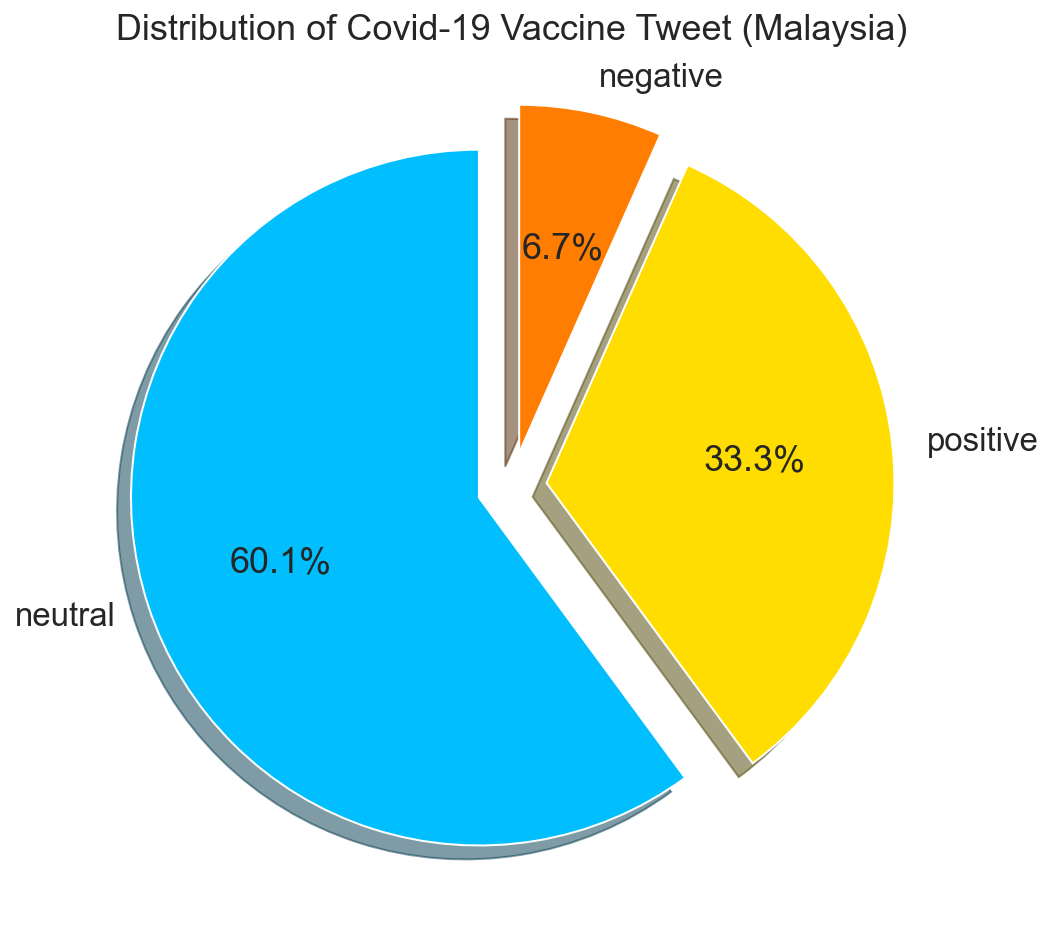

In [7]:
def distribution_graph(df, vax=None, country=None):
    #retrieve sentiment of corresponding tweet of vaccine type or country passed into function
    label = "all"
    if vax != None:
        df = df[df['vax_type'] == vax]
        label = vax
    if country != None:
        df = df[df['loc_label'] == country]
        label = country
    
    #plot pie chart
    plt.figure(figsize = (15,8))
    df['sentiment'].value_counts(normalize=True).plot.pie(autopct='%1.1f%%', shadow=True,
                                                              startangle=90, explode = (0.1,0.1,0.1))
    plt.xticks(rotation=0)
    plt.ylabel("")
    plt.title(f'Distribution of Covid-19 Vaccine Tweet (%s)' % label.capitalize())
    plt.show()

distribution_graph(df_vax, country='malaysia')

### Line Graph of Variance of Sentiment with regard to Time (Vaccine Type/Country/All)

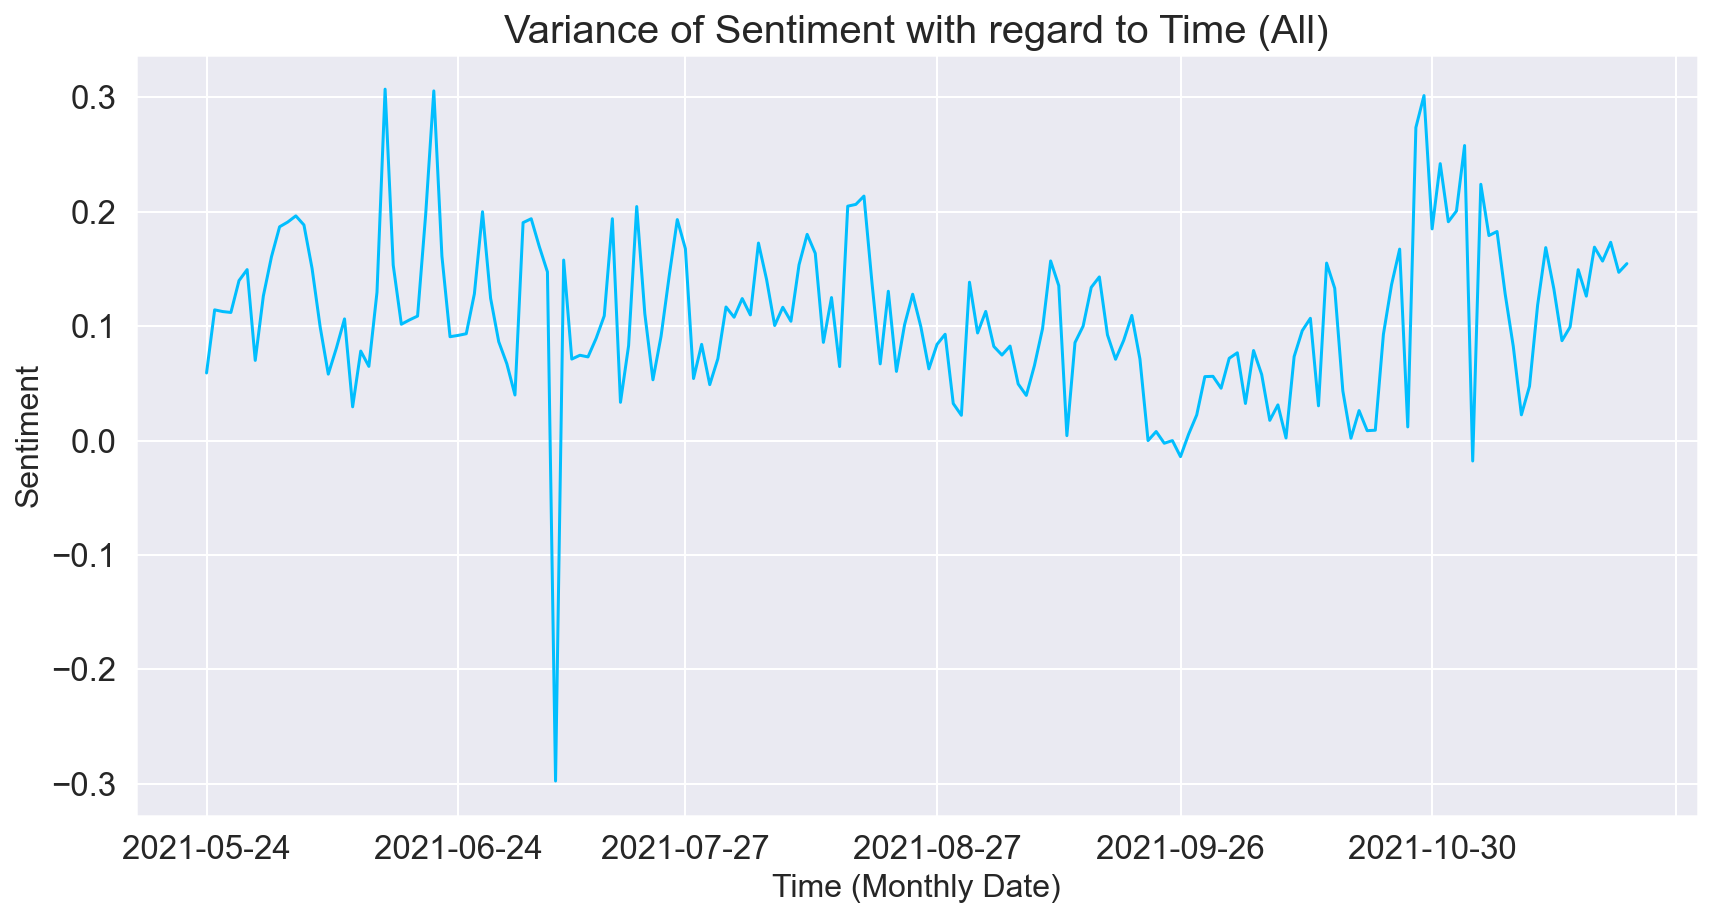

In [8]:
#function to plot line graph (sentiment variance)
def time_variance(df, vax = None, country = None):
    #retrieve sentiment of corresponding tweet of vaccine type or country passed into function
    label = "all"
    if vax != None:
        df = df[df['vax_type'] == vax]
        label = vax
    if country != None:
        df = df[df['loc_label'] == country]
        label = country

    #temporary array to store mean sentiment of each date
    temp=pd.DataFrame()
    temp['date'] = sorted(df['date'].unique())
    senti=list()
    for date in temp['date']:
        senti.append(df[df['date']==date].sentiment_num.mean())
    temp['sentiment']=senti
    
    #plot line graph
    fg,axs=plt.subplots(figsize=(14,7))
    sns.lineplot(ax=axs,x='date',y='sentiment', data= temp)
    #plot x-axis(date) as monthly date
    axs.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    axs.xaxis.set_minor_locator(mdates.MonthLocator())
    axs.set_xlabel("Time (Monthly Date)",size=16)
    axs.set_ylabel("Sentiment",size=16)
    axs.set_title(f"Variance of Sentiment with regard to Time (%s)" % label.capitalize(), size=20)
    axs.grid(True)
    
time_variance(df_vax)

### Bar Graph of Comparision of Mean Sentiment of Vaccines

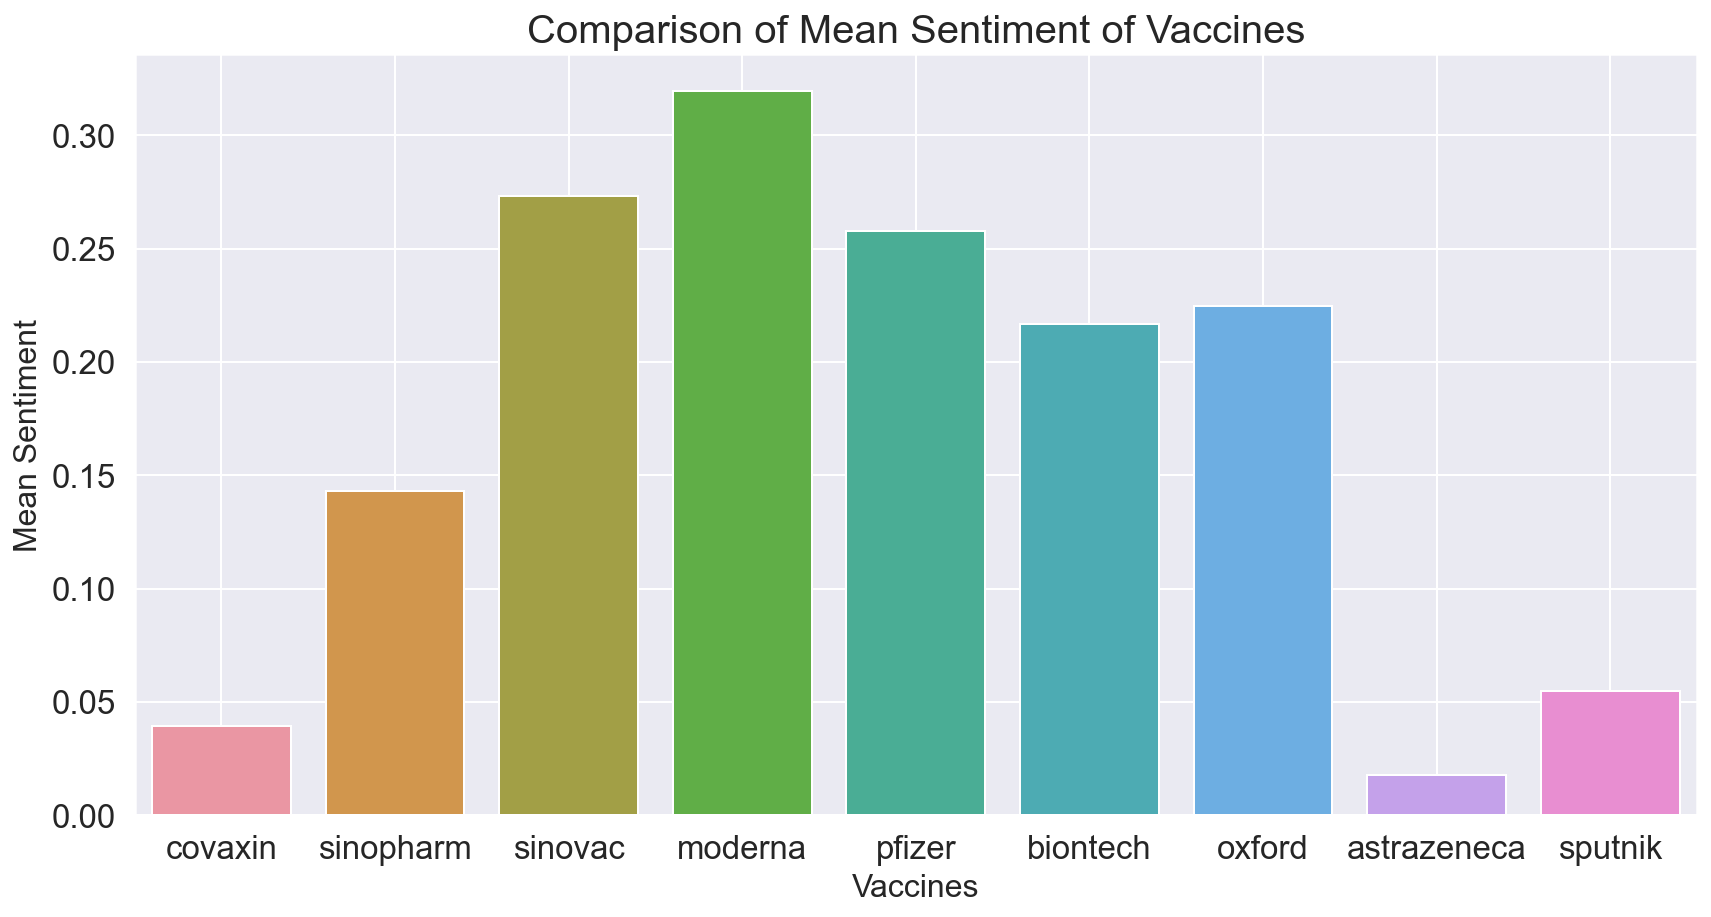

In [9]:
#dataframe to store vaccine type and mean sentiment of corresponding vaccine tweet of vaccine type
vax_sentiment = pd.DataFrame()
vax_sentiment['vaccine']=all_vax
v_senti = list()
for v in all_vax :
    v_senti.append(df_vax[df_vax['vax_type'] == v].sentiment_num.mean())
vax_sentiment['sentiment']=v_senti

#plot bar chart
fg,axs=plt.subplots(figsize=(14,7))
sns.barplot(ax=axs, x='vaccine', y='sentiment', data=vax_sentiment)
axs.set_xlabel("Vaccines",size=16)
axs.set_ylabel("Mean Sentiment",size=16)
axs.set_title("Comparison of Mean Sentiment of Vaccines",size=20)
axs.grid(True)

### Bar Graph of Comparison of Mean Sentiment of Country

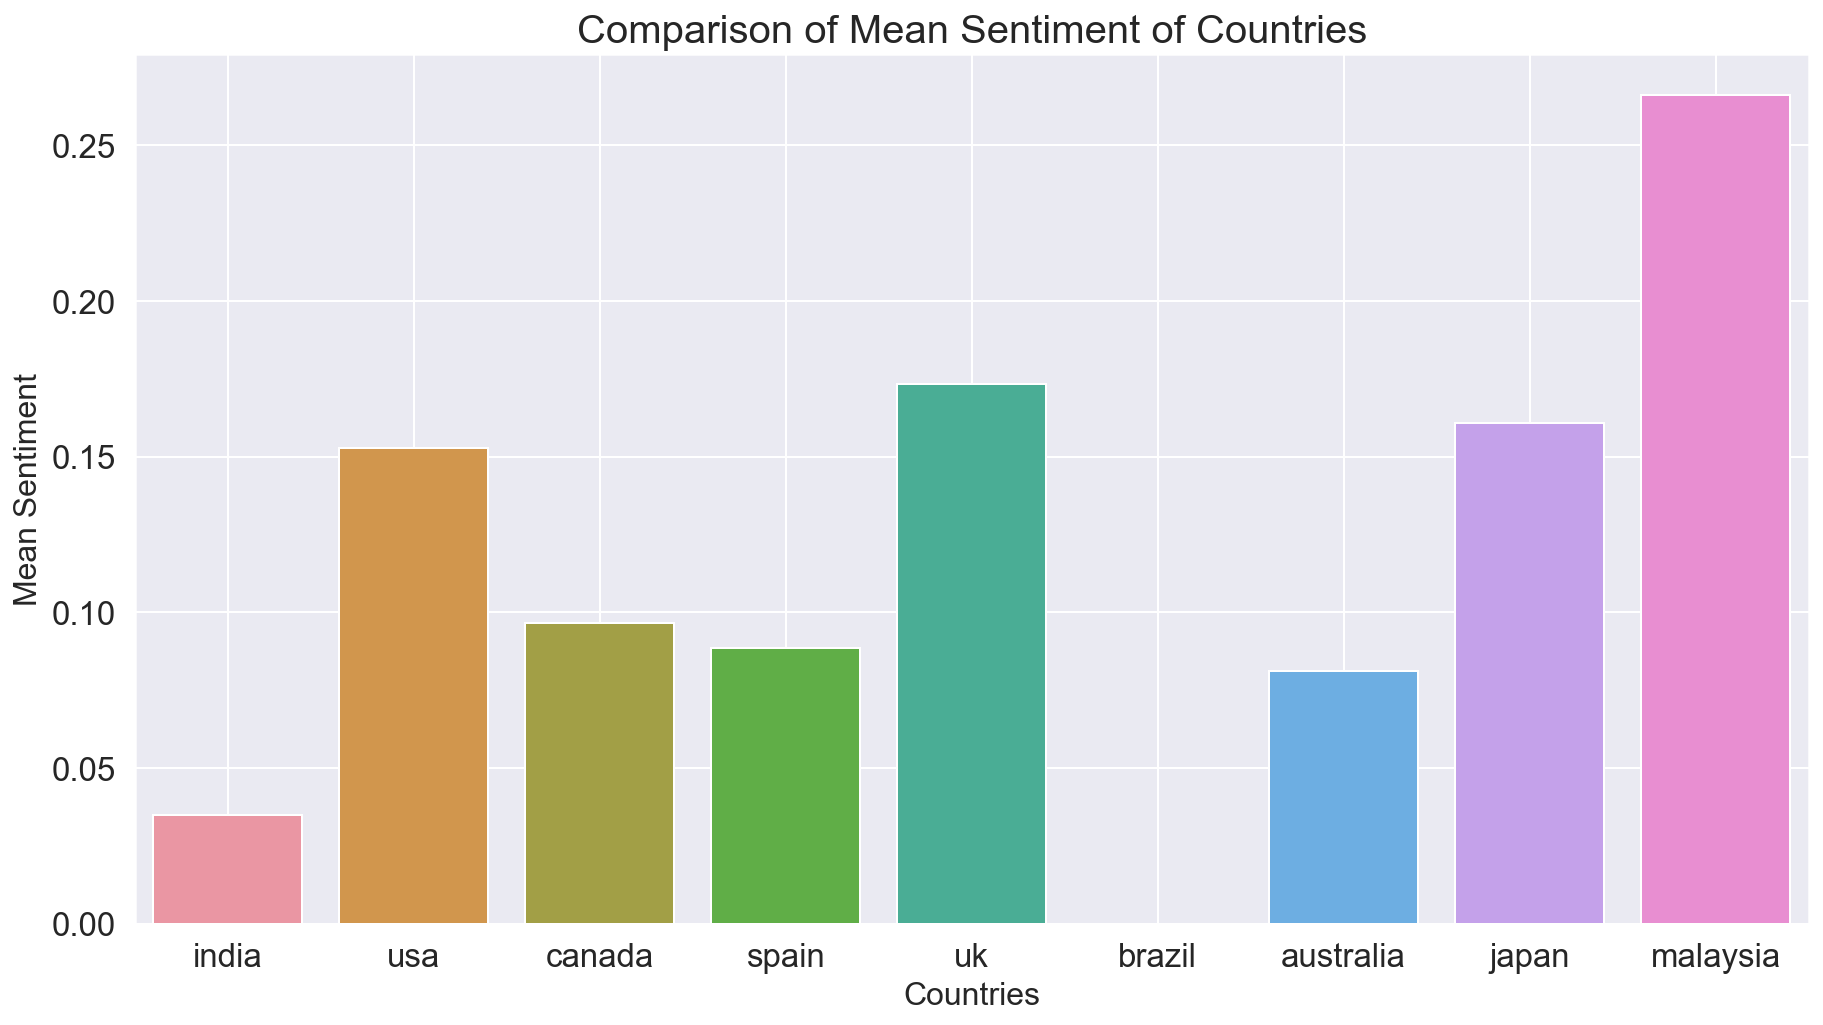

In [10]:
#dataframe to store mean sentiment of corresponding tweet based on user location
c_sentiment=pd.DataFrame()
c_sentiment['countries']=countries
c_senti=list()
for c in countries :
    c_senti.append(df_vax[df_vax['loc_label'] == c].sentiment_num.mean())
c_sentiment['sentiment']=c_senti

#plot bar chart
fg,axs=plt.subplots(figsize=(15,8))
sns.barplot(ax=axs,x='countries',y='sentiment',data=c_sentiment)
axs.set_xlabel("Countries",size=16)
axs.set_ylabel("Mean Sentiment",size=16)
axs.set_title("Comparison of Mean Sentiment of Countries",size=20)
axs.grid(True)

### Timeline Graph for Showing Sentiment of Covid-19 vaccine tweets (Vaccine Type/Country/All)

In [11]:
# Function to filter the data to a single vaccine and plot the timeline
# Note: a lot of the tweets seem to contain hashtags for multiple vaccines even though they are specifically referring to one vaccine - not very helpful!
def filtered_timeline(df, vax=None, country=None):
    #display all sentiment unless specific vaccine type or country is given
    label = "all"
    if vax != None:
        df = df[df['vax_type'] == vax]
        label = vax
    if country != None:
        df = df[df['loc_label'] == country]
        label = country
        
    # Get counts of number of tweets by sentiment for each date
    timeline = df.groupby(['date', 'sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index()
    #plot timeline graph
    fig = px.line(timeline, x='date', y='tweets', color='sentiment', 
                  category_orders={'sentiment': ['neutral', 'negative', 'positive']},
                  title=f'Timeline showing sentiment of Covid-19 vaccine tweets (%s)' % label.capitalize())
    fig.show()
    return df

covaxin = filtered_timeline(df_vax)

In [12]:
# Function to filter the data to given dates and print tweets posted on those date
def date_filter(df, date):
    return df[df['date'].astype(str)==date][['date' ,'text']]

def date_printer(df, dates, num=10): 
    for date in dates:
        display(date_filter(df, date).head(num))

date_printer(covaxin, ['2021-06-01', '2021-06-03'])

date                                               text
1716  2021-06-01  Received #PfizerBioNTech Shot #1 ! Super organ...
1717  2021-06-01  #Dubai has started offering the #PfizerBiontec...
1718  2021-06-01  1st #PfizerBiontech #Vaccine just injected int...
1719  2021-06-01  Really annoyed that my 5g reception hasn’t kic...
1720  2021-06-01  @CustomNameee I might have one soon as well cu...
1721  2021-06-01  The situation was different with the AstraZene...
1938  2021-06-01  The 1st batch of #COVID19 vaccines supplied by...
1939  2021-06-01  #Sinopharm approval by @who didn't have an upp...
1940  2021-06-01  🇨🇳Promise made &amp; promise delivered\n\nToda...
1941  2021-06-01  #China's fulfilling its commitment to the @WHO...

date                                               text
9370  2021-06-03  Another study of #PfizerBioNTech in people wit...
9371  2021-06-03  #iGotMyShot - 1st #vaccination completed. \n\n...
9372  2021-06-03  I’m just tired now. I’m grateful to be vaccina...
9373  2021-06-03  Totally high on vaxstacy. 🤩 #pfizerbiontech #f...
9374  2021-06-03  @labyrinthweaver Got my first one! #PfizerBioN...
9375  2021-06-03  #ScientificPaper: The S1 protein of SARS-CoV-2...
9376  2021-06-03  Woo-sodding-hoo! 🎉🥳 #vaxiklintoes #pfizerbiont...
9377  2021-06-03  #iGotMyShot - 1st #vaccination completed on 3r...
9378  2021-06-03  Fully vaccinated b1tch is celebrating with ice...
9379  2021-06-03  New Personal Blog Post: #iGotMyShot - 1st #vac...

### Plot WordCloud to display most frequent words in Covid-19 vaccine tweets

The WordCloud is plotted to display the most frequent words in Covid-19 vaccine tweets of respective sentiment. If a vaccine type or a country is given, the WordCloud will display the most frequent words in Covid-19 vaccine tweets of respective sentiment based on the tweets that mentioned the given vaccine type or tweets posted by user from a given location.

In [13]:
# FUNCTIONS REQUIRED

def flatten_list(l):
    return [x for y in l for x in y]

def is_acceptable(word: str):
    return word not in stop_words and len(word) > 2

# Color coding our wordclouds 
def red_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(0, 100%, {random.randint(25, 75)}%)" 

def green_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl({random.randint(90, 150)}, 100%, 30%)" 

def yellow_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(42, 100%, {random.randint(25, 50)}%)" 

# Reusable function to generate word clouds 
def generate_word_clouds(neg_doc, neu_doc, pos_doc, label):
    # Display the generated image (wordcloud):
    fig, axes = plt.subplots(3,1, figsize=(18,11))
    
    wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(neg_doc))
    axes[0].imshow(wordcloud_neg.recolor(color_func=red_color_func, random_state=3), interpolation='bilinear')
    axes[0].set_title(f"Most Frequent Words of Negative Tweets (%s)" % label.capitalize(), fontsize = 18)
    axes[0].axis("off")

    wordcloud_neu = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(neu_doc))
    axes[1].imshow(wordcloud_neu.recolor(color_func=yellow_color_func, random_state=3), interpolation='bilinear')
    axes[1].set_title("Most Frequent Words of Neutral Tweets (%s)" % label.capitalize(), fontsize = 18)
    axes[1].axis("off")

    wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(pos_doc))
    axes[2].imshow(wordcloud_pos.recolor(color_func=green_color_func, random_state=3), interpolation='bilinear')
    axes[2].set_title("Most Frequent Words of Positive Tweets (%s)" % label.capitalize(), fontsize = 18)
    axes[2].axis("off")

    plt.tight_layout()
    plt.show();

def get_top_percent_words(doc, percent):
    # Returns a list of "top-n" most frequent words in a list 
    top_n = int(percent * len(set(doc)))
    counter = Counter(doc).most_common(top_n)
    top_n_words = [x[0] for x in counter]
    
    return top_n_words
    
def clean_document(doc):
    spell = SpellChecker()
    lemmatizer = WordNetLemmatizer()
    
    # Lemmatize words (needed for calculating frequencies correctly )
    doc = [lemmatizer.lemmatize(x) for x in doc]
    
    # Get the top 10% of all words. This may include "misspelled" words 
    top_n_words = get_top_percent_words(doc, 0.1)

    # Get a list of misspelled words 
    misspelled = spell.unknown(doc)
    
    # Accept the correctly spelled words and top_n words 
    clean_words = [x for x in doc if x not in misspelled or x in top_n_words]
    
    # Try to split the misspelled words to generate good words (ex. "lifeisstrange" -> ["life", "is", "strange"])
    words_to_split = [x for x in doc if x in misspelled and x not in top_n_words]
    split_words = flatten_list([wordninja.split(x) for x in words_to_split])
    
    # Some splits may be nonsensical, so reject them ("llouis" -> ['ll', 'ou', "is"])
    clean_words.extend(spell.known(split_words))
    
    return clean_words

def get_log_likelihood(doc1, doc2):    
    doc1_counts = Counter(doc1)
    doc1_freq = {
        x: doc1_counts[x]/len(doc1)
        for x in doc1_counts
    }
    
    doc2_counts = Counter(doc2)
    doc2_freq = {
        x: doc2_counts[x]/len(doc2)
        for x in doc2_counts
    }
    
    doc_ratios = {
        # 1 is added to prevent division by 0
        x: math.log((doc1_freq[x] +1 )/(doc2_freq[x]+1))
        for x in doc1_freq if x in doc2_freq
    }
    
    top_ratios = Counter(doc_ratios).most_common()
    top_percent = int(0.1 * len(top_ratios))
    return top_ratios[:top_percent]

# Function to generate a document based on likelihood values for words 
def get_scaled_list(log_list):
    counts = [int(x[1]*100000) for x in log_list]
    words = [x[0] for x in log_list]
    cloud = []
    for i, word in enumerate(words):
        cloud.extend([word]*counts[i])
    # Shuffle to make it more "real"
    random.shuffle(cloud)
    return cloud

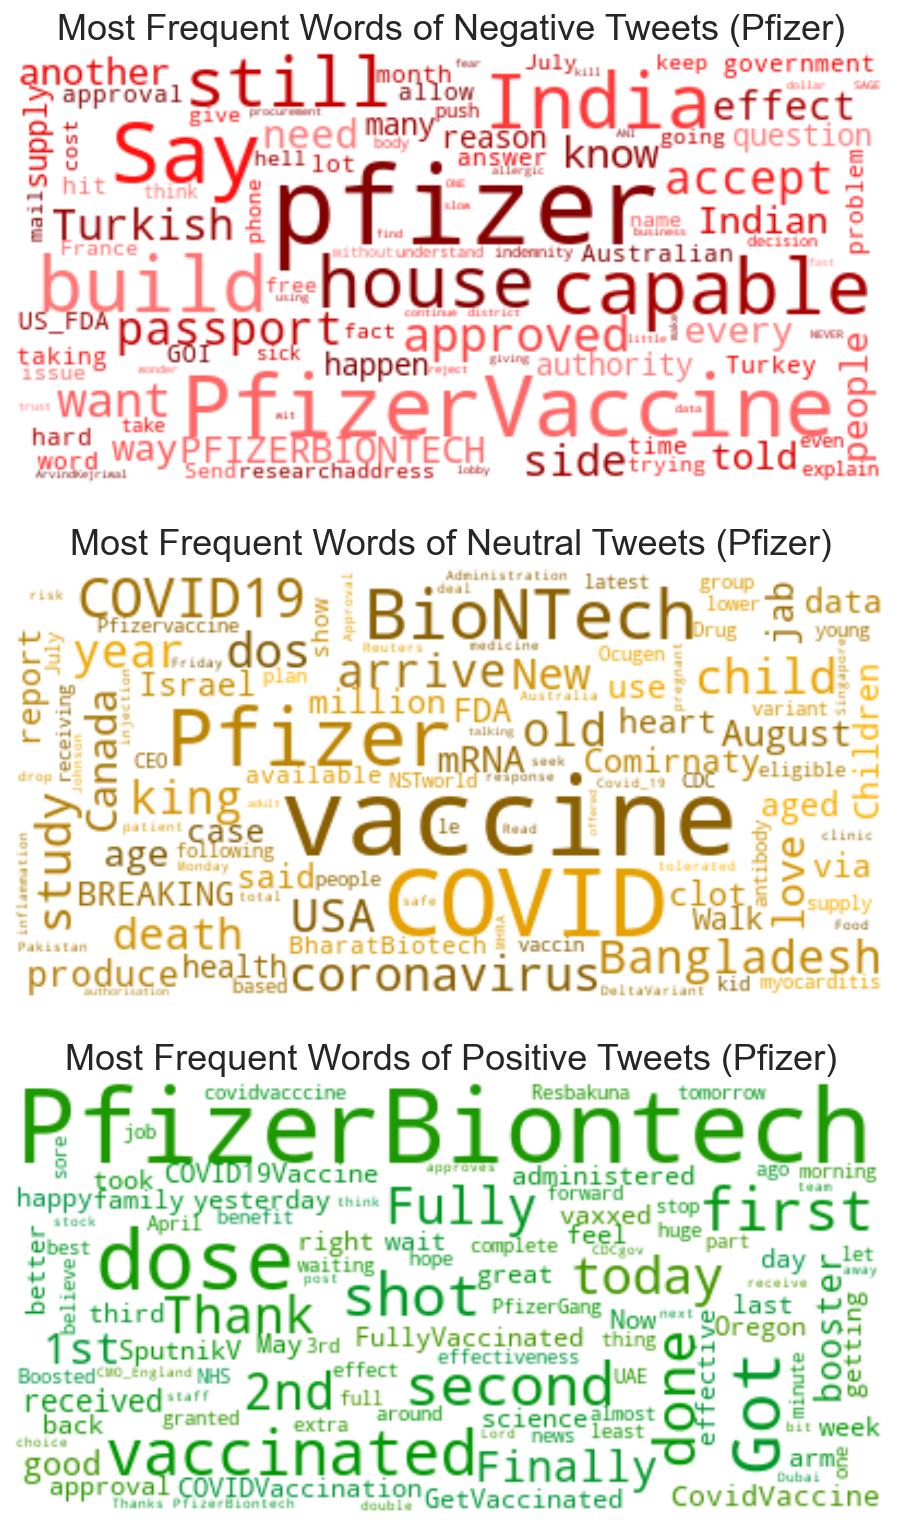

In [14]:
#get stop words list to remove stop words from tweet 
stop_words = set(stopwords.words('english'))  
stop_words.add("amp")

# Convert string to a list of words
df_vax['words'] = df_vax.text.apply(lambda x:re.findall(r'\w+', x ))

#function to calculate and plot word cloud
def get_smart_clouds(df, vax=None, country=None):
    #retrieve sentiment of corresponding tweet of vaccine type or country passed into function
    label = "all"
    if vax != None:
        df = df[df['vax_type'] == vax]
        label = vax
    if country != None:
        df = df[df['loc_label'] == country]
        label = country
    
    neg_doc = flatten_list(df[df['sentiment']=='negative']['words'])
    neg_doc = [x for x in neg_doc if is_acceptable(x)]

    pos_doc = flatten_list(df[df['sentiment']=='positive']['words'])
    pos_doc = [x for x in pos_doc if is_acceptable(x)]

    neu_doc = flatten_list(df[df['sentiment']=='neutral']['words'])
    neu_doc = [x for x in neu_doc if is_acceptable(x)]

    # Clean all the documents
    neg_doc_clean = clean_document(neg_doc)
    neu_doc_clean = clean_document(neu_doc)
    pos_doc_clean = clean_document(pos_doc)

    # Combine classes B and C to compare against A (ex. "positive" vs "non-positive")
    top_neg_words = get_log_likelihood(neg_doc_clean, flatten_list([pos_doc_clean, neu_doc_clean]))
    top_neu_words = get_log_likelihood(neu_doc_clean, flatten_list([pos_doc_clean, neg_doc_clean]))
    top_pos_words = get_log_likelihood(pos_doc_clean, flatten_list([neu_doc_clean, neg_doc_clean]))

    # Generate syntetic a corpus using our loglikelihood values 
    neg_doc_final = get_scaled_list(top_neg_words)
    neu_doc_final = get_scaled_list(top_neu_words)
    pos_doc_final = get_scaled_list(top_pos_words)

    # Visualise our synthetic corpus
    generate_word_clouds(neg_doc_final, neu_doc_final, pos_doc_final, label)
    
get_smart_clouds(df_vax, vax='pfizer', country=None)

### Extract Semantic and Meaningful Keyword From Covid-19 Vaccine Tweet Input and Perform Google News Query with Extracted Keyword

Covid-19 Vaccine Tweet Input will first be analyzed and the sentiment of it will be predicted using the fine-tuned BERT. The fine-tuned BERT model will be loaded using the torch python module. After sentiment analysis is performed on the Covid-19 vaccine tweet input, a process to extract semantic and meaningful keyword from the tweet input will be perform to retrieve keywords from the tweet input. 

The python module used for extracting keywords is KeyBert which is a minimal and easy-to-use keyword extraction technique that leverages BERT embeddings to create keywords and keyphrases that are most similar to a document.

After that, the keywords that are extracted from the tweet will be use to perform queries on google news feed to provides news related to the keywords extracted. The python module that will be used is the pygooglenews module.

In [15]:
#input tweet (using random tweet from covid-19 vaccine tweet dataset as example)
# tweet_input = input("Enter Tweet:")  #uncomment when necessary
tweet_input = df_vax.text[10]  #comment when necessary
#remove url in tweet input 
url_pattern = re.compile(r'https?://\S+|www\.\S+')
tweet_input = url_pattern.sub(r'', tweet_input)

In [16]:
#import bert model for keyword extraction 
keyword_model = KeyBERT(model = "princeton-nlp/sup-simcse-bert-base-uncased")

In [17]:
#extract and display keywords
k_words = keyword_model.extract_keywords(tweet_input, top_n=3,use_mmr=True, keyphrase_ngram_range=(1,2),
                               stop_words="english", highlight=True)
print("Keywords Extracted:-\n", k_words, '\n')
#retrieve the string of the result of the keyword extraction
words_Str = ' '.join([str(elem) for elem in k_words])
syntax = re.compile("'[^']*'")
for value in syntax.findall(words_Str):
    print(value)

Germany serves up Covid jabs in the company canteen #PfizerBiontech #EvonikIndustries 
#Germany #Volkswagen…

Keywords Extracted:-
 [('pfizerbiontech evonikindustries', 0.7369), ('company canteen', 0.5864), ('germany volkswagen', 0.6296)] 

'pfizerbiontech evonikindustries'
'company canteen'
'germany volkswagen'


In [18]:
#google news query with extracted keywords for english langugage news only
gn = GoogleNews(lang = 'en')
print("Google News Query Results:-")
for value in syntax.findall(words_Str):
    print(value)
    search = gn.search(value)
    newsitem = search['entries']
    print(newsitem[0].title)
    print(newsitem[0].link)

Google News Query Results:-
'pfizerbiontech evonikindustries'
Evonik starts lipid deliveries for Pfizer/BioNTech COVID-19 vaccine ahead of time - Reuters
https://www.reuters.com/article/health-coronavirus-evonik-idUSL1N2MF0OC
'company canteen'
Meet Bolk, a Robotic Bowl Food Canteen Company That Just Raised €4M - The Spoon
https://thespoon.tech/meet-bolk-a-robotic-bowl-food-canteen-company-that-just-raised-e4m/
'germany volkswagen'
Ship carrying Porsches and Bentleys ablaze near Azores, towing boats en route - Reuters
https://www.reuters.com/business/container-ship-carrying-volkswagen-vehicles-catches-fire-near-azores-2022-02-18/
